In [2]:
import scanpy as sc
import numpy as np

In [3]:
adata=sc.read("data/adata_processed.h5ad")

In [4]:
temp_X=adata.X.copy()

In [5]:
adata.X=sc.pp.scale(adata.layers["palantir_imp"],max_value=10)

In [6]:
sc.tl.score_genes(adata,["Ret", "Phox2a", "Chrna3","Sox11"],score_name="Gut_neuron",)
adata.obs.Gut_neuron=(adata.obs.Gut_neuron>1.5)
sc.tl.score_genes(adata,["Prdm12","Isl2","Pou4f1","Six1"],score_name="Sensory")
adata.obs.Sensory=(adata.obs.Sensory>1)
sc.tl.score_genes(adata,["Cartpt","Prph","Mapt","Maoa"],score_name="Symp")
adata.obs.Symp=(adata.obs.Symp>1.5)
sc.tl.score_genes(adata,["Lum","Dcn","Fbn1"],score_name="enFib")
adata.obs.enFib=(adata.obs.enFib>2.5)
sc.tl.score_genes(adata,["Th","Dbh","Chga","Chgb","Slc18a1","Slc18a2"],score_name="ChC")
adata.obs.ChC=(adata.obs.ChC>2)
sc.tl.score_genes(adata,["Phox2b","Ctgf","Nfia","Tgfb2","S100b"],score_name="Gut_glia")
adata.obs.Gut_glia=(adata.obs.Gut_glia>2.5)
sc.tl.score_genes(adata,["Sox9","Wnt1","Ets1","Crabp2"],score_name="NCC")
adata.obs.NCC=(adata.obs.NCC>.6)
sc.tl.score_genes(adata,["Prrx1","Prrx2","Pdgfra"],score_name="Mesenchyme")
adata.obs.Mesenchyme=(adata.obs.Mesenchyme>.4)
sc.tl.score_genes(adata,["Dct","Mitf","Pmel","Tyr"],score_name="Melanocytes")
adata.obs.Melanocytes=(adata.obs.Melanocytes>1)
sc.tl.score_genes(adata,["Fabp7","Ptn","Rgcc"],score_name="SatGlia")
adata.obs.SatGlia=(adata.obs.SatGlia>2.6)

In [7]:
sc.tl.score_genes(adata,["Mpz","Plp1","Fbxo7","Gjc3","Pmp22","Dhh","Mal"],score_name="SC")
adata.obs.SC=(adata.obs.SC>1.35)

In [8]:
sc.tl.score_genes(adata,["Prss56","Egr2","Wif1","Hey2"],score_name="BCC")
adata.obs.BCC=(adata.obs.BCC>6)

In [9]:
celltypes=["NCC","Symp","ChC","Sensory","Gut_glia","Gut_neuron","Melanocytes","SC","enFib","Mesenchyme","SatGlia","BCC"]
adata.obs["conflict"]=adata.obs[celltypes].sum(axis=1)>1

adata.obs.loc[adata.obs[celltypes].sum(axis=1)>1,celltypes]=False

adata.obs.loc[adata.obs[celltypes].sum(axis=1)==2,celltypes]=False

annot=adata.obs.loc[:,celltypes].apply(lambda x:np.argwhere(x.values),axis=1)
annot=annot[annot.apply(len)==1]
annot=annot.apply(lambda x: np.array(celltypes)[x][0][0])

adata.obs["assignments"]="none"
adata.obs.loc[annot.index,"assignments"]=annot.values
adata.obs["assignments"]=adata.obs["assignments"].astype("category")



In [10]:
adata.obs.assignments.cat.categories

Index(['BCC', 'ChC', 'Gut_glia', 'Gut_neuron', 'Melanocytes', 'Mesenchyme',
       'NCC', 'SC', 'SatGlia', 'Sensory', 'Symp', 'enFib', 'none'],
      dtype='object')

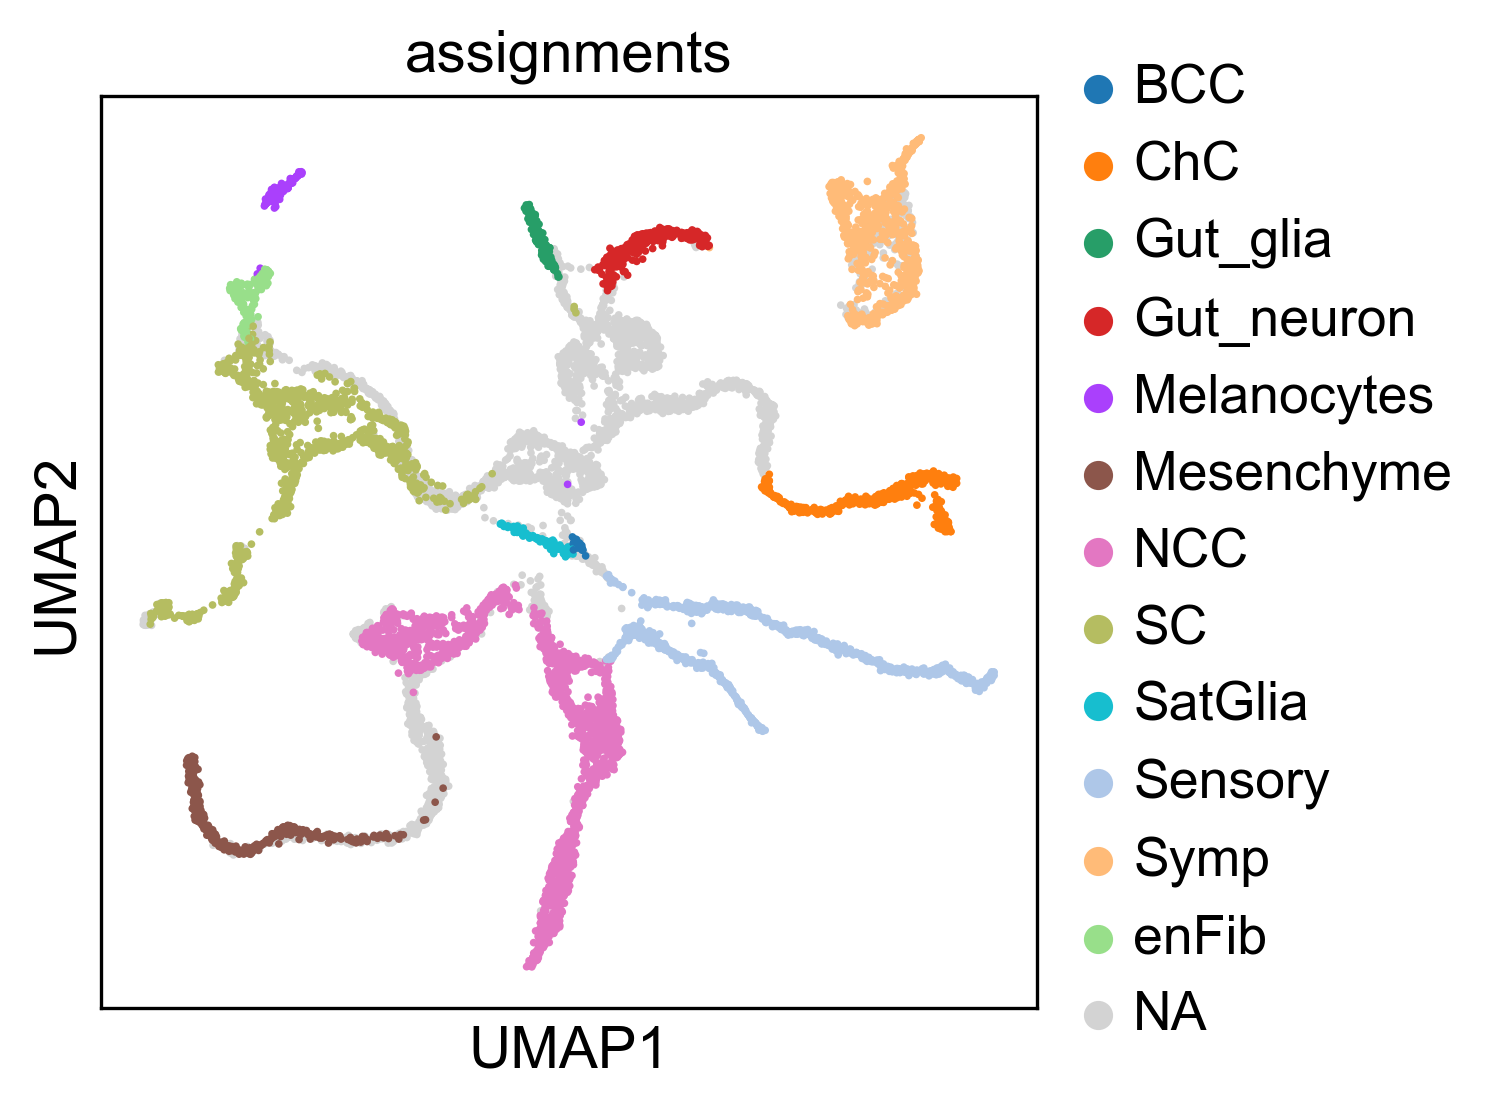

In [16]:
sc.set_figure_params(dpi=150)
sc.pl.umap(adata,color="assignments",groups=celltypes)

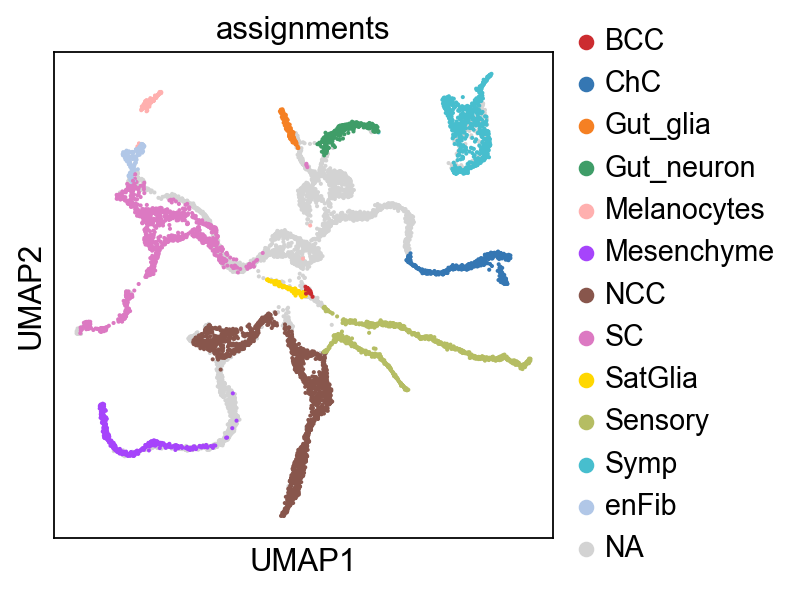

In [20]:
sc.set_figure_params()
sc.pl.umap(adata,color="assignments",
           palette=["#CC2C30","#3577B3","#F58023","#3F9D68","#FFB0AF","#A644FB","#88564C","#DC79C2","gold","#B5BD63","#47BECE","#B1C7E7","lightgrey",],
           groups=celltypes)

In [21]:
adata.obs["Hub"]=(~adata.obs["conflict"]) & (adata.obs["assignments"]=="none")

In [22]:
adata.obs["Hub"]=adata.obs["Hub"].astype("category")

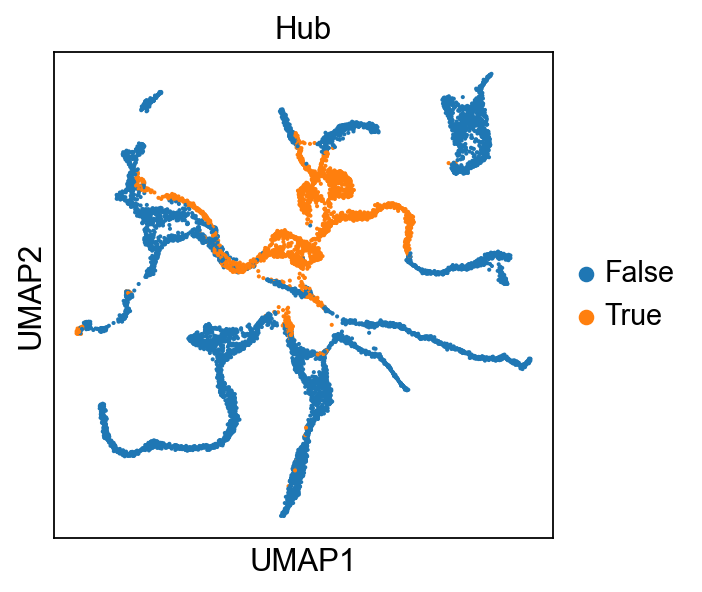

In [23]:
sc.pl.umap(adata,color="Hub")

In [24]:
props=adata.obs.groupby("leiden").apply(lambda x: len(x.Hub[x.Hub==True])/len(x.Hub))

In [25]:
hub_leiden=props.index[props>.8].tolist()

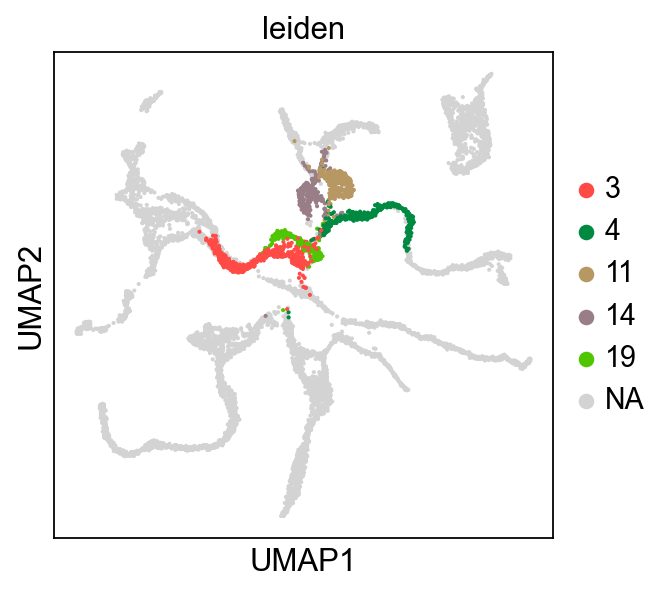

In [26]:
sc.pl.umap(adata,color="leiden",groups=hub_leiden)

In [27]:
adata.obs["Hub_leiden"]=adata.obs.leiden.isin(hub_leiden).astype(str)

In [28]:
adata.obs["Hub"]=adata.obs["Hub"].astype("category").astype(str)

In [29]:
adata.X=temp_X

In [30]:
adata.write("data/adata_assigned.h5ad")

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Hub' as categorical
/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Hub_leiden' as categorical


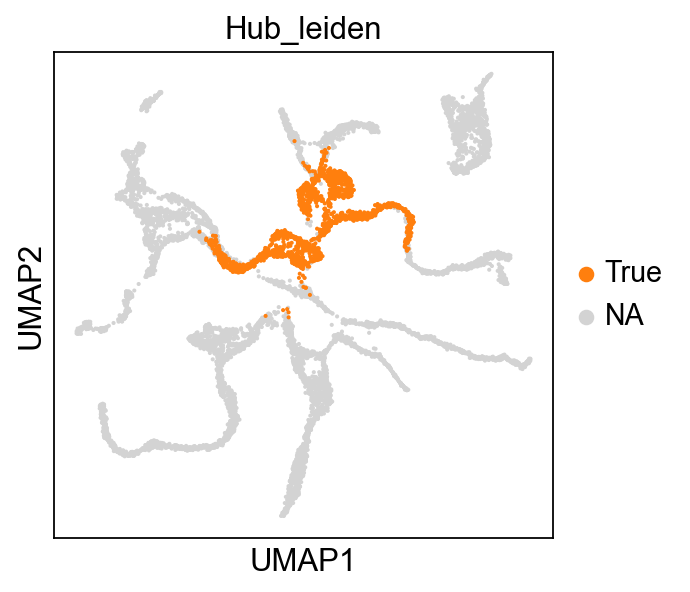

In [59]:
sc.pl.umap(adata,color="Hub_leiden",groups=["True"])

In [60]:
sc.tl.rank_genes_groups(adata,"Hub_leiden",method="wilcoxon",pts=True)

In [61]:
sc.get.rank_genes_groups_df(adata,"True").set_index("names").iloc[:60]

,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
names,,,,,,
Nell2,46.596775,5.638632,0.000000e+00,0.000000e+00,0.902192,0.358346
Cdkn1c,42.456917,3.612067,0.000000e+00,0.000000e+00,0.987634,0.847232
Cdh6,42.032894,3.933254,0.000000e+00,0.000000e+00,0.967397,0.617301
Spon1,41.756454,4.357112,0.000000e+00,0.000000e+00,0.955593,0.598471
Rbp1,40.433224,3.686890,0.000000e+00,0.000000e+00,0.943227,0.727028
Dlx1,40.386703,4.319792,0.000000e+00,0.000000e+00,0.814503,0.250035
Lmo4,40.366871,3.081400,0.000000e+00,0.000000e+00,0.935919,0.740903
Slitrk6,39.851295,5.584491,0.000000e+00,0.000000e+00,0.784148,0.210109
Cthrc1,39.727791,4.000606,0.000000e+00,0.000000e+00,0.876335,0.496956


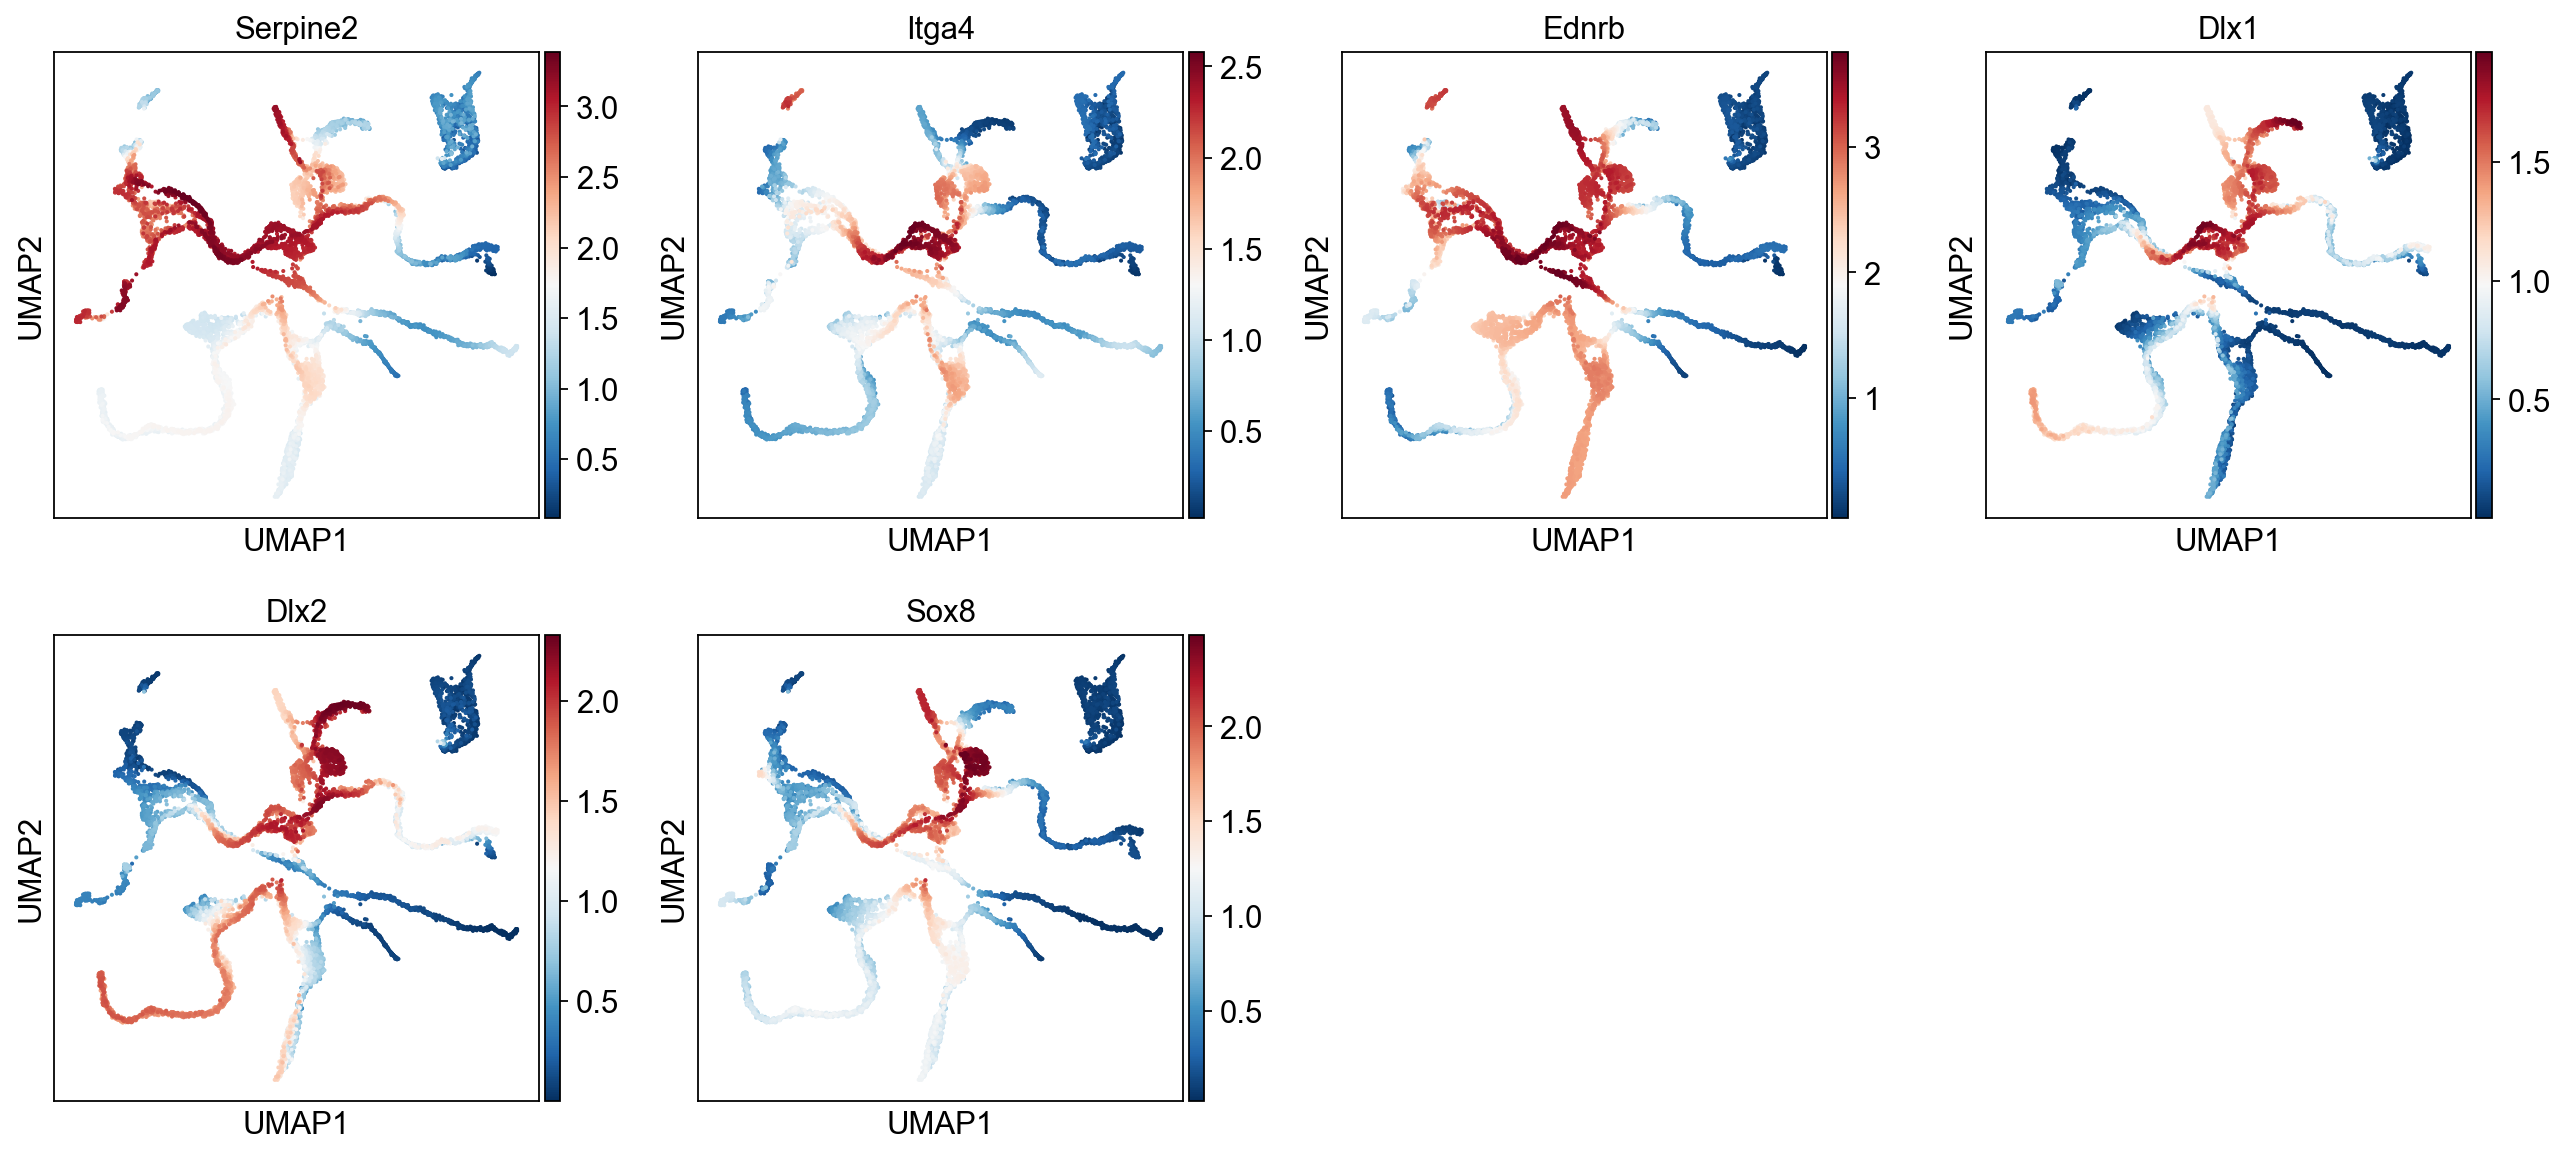

In [63]:
sc.pl.umap(adata,color=["Serpine2","Itga4","Ednrb","Dlx1","Dlx2","Sox8"],layer="palantir_imp",cmap="RdBu_r")

In [34]:
sc.get.rank_genes_groups_df(adata,"True").set_index("names").iloc[:60]

,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
names,,,,,,
Nell2,45.103340,5.019799,0.000000e+00,0.000000e+00,0.821889,0.334930
Spon1,44.415619,4.252909,0.000000e+00,0.000000e+00,0.931336,0.572643
Ednrb,41.686283,4.342368,0.000000e+00,0.000000e+00,0.936746,0.643122
Ldhb,41.100163,2.612332,0.000000e+00,0.000000e+00,0.985851,0.810819
Grb10,40.308990,1.568629,0.000000e+00,0.000000e+00,0.996255,0.953014
Cdh6,40.148083,3.489766,0.000000e+00,0.000000e+00,0.922181,0.597991
Id3,39.284561,3.288559,0.000000e+00,0.000000e+00,0.959218,0.728439
Lmo4,39.092892,2.879902,0.000000e+00,0.000000e+00,0.936330,0.721175
Sox8,37.873367,3.661790,0.000000e+00,0.000000e+00,0.759883,0.380989
